In [9]:
#     API Alpaca
#     Data cleanup
#     Consumer Discretionary Monte Carlo = XLY
#     Consumer Staples Monte Carlo = XLP
#     SP500 GROWTH Monte Carlo = SGX

In [1]:
#Import libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os 


%matplotlib inline

In [7]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
APCA_API_KEY_ID = os.getenv("APCA_API_KEY")
APCA_SECRET_KEY = os.getenv("APCA_SECRET_KEY")

api = tradeapi.REST(APCA_API_KEY_ID, APCA_SECRET_KEY, api_version='v2')
type(APCA_API_KEY_ID)

str

In [11]:
#Use alpha vantage to get historic quotes for XLY,XLP,SGX. This goes back 20 years.

xly_df = api.alpha_vantage.historic_quotes('XLY', adjusted=True, output_format='pandas')
xly_df.head()

xlp_df = api.alpha_vantage.historic_quotes('XLP', adjusted=True, output_format='pandas')
#xlp_df.tail()

sgx_df = api.alpha_vantage.historic_quotes('SGX', adjusted=True, output_format='pandas')
#sgx_df.head()


In [12]:
xly_df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-04-28,116.49,116.90,114.220,114.80,114.80,4663133.0,0.0,1.0
2020-04-27,113.40,115.09,113.290,114.35,114.35,4118447.0,0.0,1.0
2020-04-24,111.52,112.75,110.495,112.25,112.25,2914498.0,0.0,1.0
2020-04-23,110.96,112.02,109.980,110.38,110.38,4129555.0,0.0,1.0
2020-04-22,110.09,111.18,109.470,110.41,110.41,3385548.0,0.0,1.0


In [13]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

xly_df = xly_df['5. adjusted close']
xly_df.head()

xlp_df = xlp_df['5. adjusted close']
xlp_df.head()

sgx_df = sgx_df['5. adjusted close']
sgx_df.head()

#Use concat to put the data in one dataframe
concat_df = pd.concat([xly_df, xlp_df, sgx_df], axis = "columns", join = "inner")
concat_df.head()
    

,5. adjusted close,5. adjusted close,5. adjusted close
date,,,
2020-04-27,114.35,58.88,1868.83
2020-04-24,112.25,58.71,1850.60
2020-04-23,110.38,58.09,1823.75
2020-04-22,110.41,58.61,1826.15
2020-04-21,108.08,58.05,1775.70


In [45]:
#print column names
print(concat_df.columns)

Index(['SGX Adjusted Close', 'SGX Adjusted Close', 'SGX Adjusted Close'], dtype='object')


In [52]:
#Change column names to avoid confusion
columns = ['XLY close', 'XLP close', 'SGX close']
concat_df.columns = columns
concat_df.head()

,XLY close,XLP close,SGX close
date,,,
2020-04-27,114.35,58.88,1868.83
2020-04-24,112.25,58.71,1850.60
2020-04-23,110.38,58.09,1823.75
2020-04-22,110.41,58.61,1826.15
2020-04-21,108.08,58.05,1775.70


In [53]:
#add another column to get daily returns of XLY
daily_returns_xly = xly_df.pct_change()
concat_df['XLY_return']= daily_returns_xly 

#add another column to get daily returns of XLP
daily_returns_xlp = xlp_df.pct_change()
concat_df['XLP_return']= daily_returns_xlp 

#add another column to get daily returns of SGX
daily_returns_sgx = sgx_df.pct_change()
concat_df['SGX_return']= daily_returns_sgx 

concat_df.head()

,XLY close,XLP close,SGX close,XLY_return,XLP_return,SGX_return
date,,,,,,
2020-04-27,114.35,58.88,1868.83,-0.003920,-0.005573,NaN
2020-04-24,112.25,58.71,1850.60,-0.018365,-0.002887,-0.009755
2020-04-23,110.38,58.09,1823.75,-0.016659,-0.010560,-0.014509
2020-04-22,110.41,58.61,1826.15,0.000272,0.008952,0.001316
2020-04-21,108.08,58.05,1775.70,-0.021103,-0.009555,-0.027626


In [54]:
#check for nulls

concat_df.isnull().sum()

XLY close     0
XLP close     0
SGX close     0
XLY_return    0
XLP_return    0
SGX_return    1
dtype: int64

In [55]:
# Drop nulls
concat_df.dropna(inplace=True)

#count nulls again
concat_df.isnull().sum()

XLY close     0
XLP close     0
SGX close     0
XLY_return    0
XLP_return    0
SGX_return    0
dtype: int64

In [56]:
# Checking for duplicate rows
concat_df.duplicated()

date
2020-04-24    False
2020-04-23    False
2020-04-22    False
2020-04-21    False
2020-04-20    False
              ...  
2000-05-05    False
2000-05-04    False
2000-05-03    False
2000-05-02    False
2000-05-01    False
Length: 5028, dtype: bool

In [57]:
# drop duplicates
concat_df.drop_duplicates(inplace=True)

In [59]:
concat_df

,XLY close,XLP close,SGX close,XLY_return,XLP_return,SGX_return
date,,,,,,
2020-04-24,112.2500,58.7100,1850.60,-0.018365,-0.002887,-0.009755
2020-04-23,110.3800,58.0900,1823.75,-0.016659,-0.010560,-0.014509
2020-04-22,110.4100,58.6100,1826.15,0.000272,0.008952,0.001316
2020-04-21,108.0800,58.0500,1775.70,-0.021103,-0.009555,-0.027626
2020-04-20,110.9600,59.3100,1836.67,0.026647,0.021705,0.034336
...,...,...,...,...,...,...
2000-05-05,21.6164,14.6113,866.12,0.002886,-0.020250,0.016967
2000-05-04,21.3445,14.2778,846.30,-0.012578,-0.022825,-0.022884
2000-05-03,21.7018,14.2778,851.44,0.016740,0.000000,0.006073


In [60]:
#Check datatypes

concat_df.dtypes

XLY close     float64
XLP close     float64
SGX close     float64
XLY_return    float64
XLP_return    float64
SGX_return    float64
dtype: object

In [61]:
#check counts
concat_df.count()

XLY close     5028
XLP close     5028
SGX close     5028
XLY_return    5028
XLP_return    5028
SGX_return    5028
dtype: int64

In [62]:
#use describe to explore data
concat_df.describe()

,XLY close,XLP close,SGX close,XLY_return,XLP_return,SGX_return
count,5028.000000,5028.000000,5028.000000,5028.000000,5028.000000,5028.000000
mean,46.847216,28.631587,867.168016,-0.000220,-0.000237,-0.000069
std,30.546083,14.740906,402.981158,0.014149,0.009538,0.012618
min,13.621800,11.666100,363.990000,-0.104402,-0.083707,-0.113694
25%,24.375900,16.229300,575.747500,-0.007073,-0.005110,-0.005796
50%,31.281350,20.779600,683.945000,-0.000787,-0.000443,-0.000616
75%,69.769875,42.654475,1125.919925,0.005799,0.004199,0.004843
max,131.682600,64.409400,2120.379900,0.145063,0.103699,0.139774


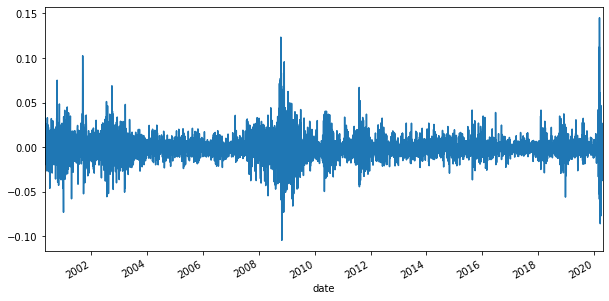

In [63]:
#plot daily returns of XLY

concat_df['XLY_return'].plot(figsize=(10,5))

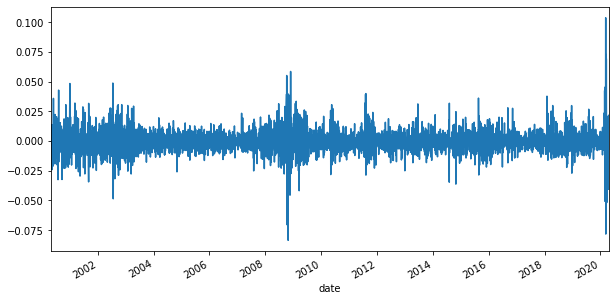

In [64]:
#plot daily returns of XLP

concat_df['XLP_return'].plot(figsize=(10,5))

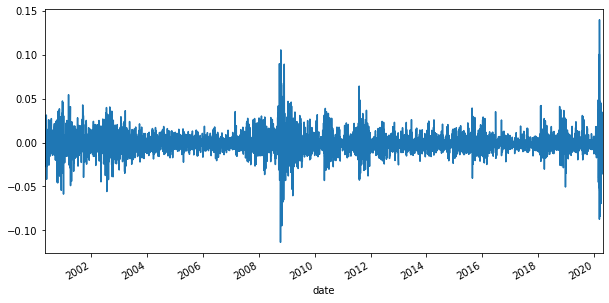

In [66]:
#plot daily returns of SGX

concat_df['SGX_return'].plot(figsize=(10,5))

In [68]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_xly = (1 + daily_returns_xly).cumprod()
cumulative_returns_xlp = (1 + daily_returns_xlp).cumprod()
cumulative_returns_sgx = (1 + daily_returns_sgx).cumprod()

cumulative_returns_xly.head()

date
2020-04-28         NaN
2020-04-27    0.996080
2020-04-24    0.977787
2020-04-23    0.961498
2020-04-22    0.961760
Name: 5. adjusted close, dtype: float64

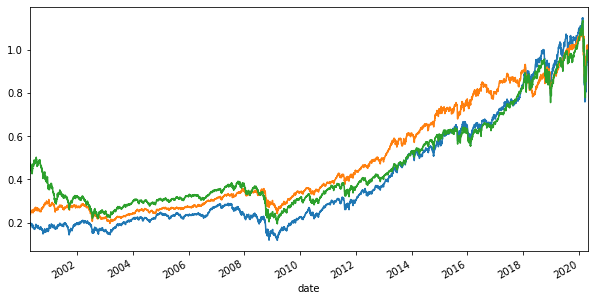

In [70]:
#plot cumulative returns

cumulative_returns_xly.plot(figsize=(10,5))
cumulative_returns_xlp.plot(figsize=(10,5))
cumulative_returns_sgx.plot(figsize=(10,5))

In [ ]:
#need to check on dividend